# 阶段一：全局数据准备与参数设定

步骤 1.1：加载与合并多日原始数据

============= 基于图像块处理 - 阶段一 =============

--- 步骤 1.1: 加载与合并多日原始数据 ---

开始加载 20200101 到 20200331 的每日原始SST数据...
已加载 91 天的数据。
开始沿时间维度合并数据...
全局原始SST数据合并完成。形状 (time, lat, lon) = (91, 721, 1440)
<xarray.Dataset> Size: 378MB
Dimensions:    (time: 91, longitude: 1440, latitude: 721)
Coordinates:
  * time       (time) datetime64[ns] 728B 2020-01-01 2020-01-02 ... 2020-03-31
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
Data variables:
    sst        (time, latitude, longitude) float32 378MB 271.5 271.5 ... nan nan


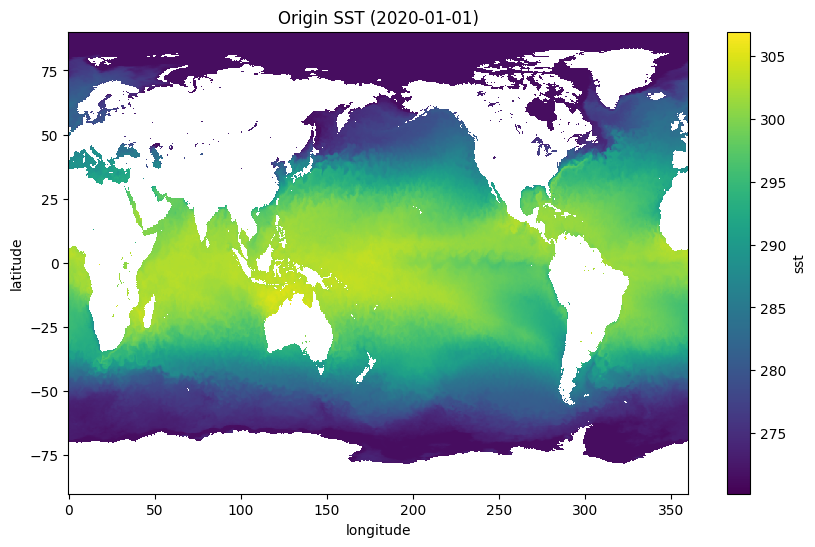


--- 执行时间序列上的训练/测试集划分 ---
训练集时间范围: 2020-01-01 to 2020-03-26 (86 days)
测试集时间范围: 2020-03-27 to 2020-03-31 (5 days)


In [13]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch 
import json

print("============= 基于图像块处理 - 阶段一 =============")

# --- 步骤 1.1: 加载与合并多日原始数据 ---
print("\n--- 步骤 1.1: 加载与合并多日原始数据 ---\n")

# 基础参数
root_path = '../data/raw/ERA5/' # TODO：请确保路径正确
start_date_full_period_str = '20200101'
end_date_full_period_str = '20200331' # 2020年1月1日至3月31日的SST数据
save_era5_dir = '../data/processed/ERA5/' # 保存目录，稍后会用到

## 变量名
temp_var_name = sst_var_name = 'sst'
lat_coord_name = 'latitude'
lon_coord_name = 'longitude'
time_coord_name = 'time'

# 日期生成
dates_to_load_full = pd.date_range(start=start_date_full_period_str, end=end_date_full_period_str, freq='D')

list_of_data_arrays = []
actual_loaded_dates_full = []

print(f"开始加载 {start_date_full_period_str} 到 {end_date_full_period_str} 的每日原始SST数据...")
for date_val in dates_to_load_full:
    date_str = date_val.strftime('%Y%m%d')
    filename = f"{date_str}_ERA5_daily_mean_sst.nc"
    file_full_path = os.path.join(root_path, filename)
    try:
        daily_ds = xr.open_dataset(file_full_path)
        sst_data_array = daily_ds[sst_var_name].expand_dims(dim={time_coord_name: [date_val]}) # 使用 pandas datetime 对象作为坐标
        list_of_data_arrays.append(sst_data_array)
        actual_loaded_dates_full.append(date_val)
    except FileNotFoundError:
        print(f"警告: 文件 {file_full_path} 未找到，已跳过。")
    except KeyError:
        print(f"警告: 文件 {file_full_path} 中未找到变量 '{sst_var_name}'，已跳过。")
    except Exception as e:
        print(f"加载或处理文件 {file_full_path} 时发生错误: {e}")

if not list_of_data_arrays:
    print("错误：未能成功加载任何数据文件。程序将终止。")
    exit()

print(f"已加载 {len(actual_loaded_dates_full)} 天的数据。")

print("开始沿时间维度合并数据...")
time_coordinate_full = pd.Index(actual_loaded_dates_full, name=time_coord_name)
ds_global_raw_sst_da = xr.concat(list_of_data_arrays, dim=time_coordinate_full)
ds_global_raw_sst_da.name = sst_var_name
ds_global_raw = ds_global_raw_sst_da.to_dataset() # 转换为dataset


print(f"全局原始SST数据合并完成。形状 (time, lat, lon) = {ds_global_raw[sst_var_name].shape}")
print(ds_global_raw)

# 检查一个切片
plt.figure(figsize=(10, 6))
ds_global_raw[sst_var_name].isel({time_coord_name: 0}).plot(cmap='viridis')
plt.title(f'Origin SST ({pd.to_datetime(str(ds_global_raw[time_coord_name].values[0])).strftime("%Y-%m-%d")})')
plt.xlabel(lon_coord_name)
plt.ylabel(lat_coord_name)
plt.show()

# --- 执行时间序列上的训练/测试集划分 ---
print("\n--- 执行时间序列上的训练/测试集划分 ---")
num_test_days = 5
if len(ds_global_raw[time_coord_name]) <= num_test_days:
    print(f"错误：数据总天数 ({len(ds_global_raw[time_coord_name])}) 不足以划分出 {num_test_days} 天的测试集。")
    exit()

# 按时间划分
# 测试集是最后 num_test_days 天
ds_test_raw = ds_global_raw.isel({time_coord_name: slice(-num_test_days, None)})
# 训练集是除了最后 num_test_days 天之外的所有数据
ds_train_raw = ds_global_raw.isel({time_coord_name: slice(None, -num_test_days)})

print(f"训练集时间范围: {ds_train_raw[time_coord_name].min().dt.strftime('%Y-%m-%d').item()} to {ds_train_raw[time_coord_name].max().dt.strftime('%Y-%m-%d').item()} ({len(ds_train_raw[time_coord_name])} days)")
print(f"测试集时间范围: {ds_test_raw[time_coord_name].min().dt.strftime('%Y-%m-%d').item()} to {ds_test_raw[time_coord_name].max().dt.strftime('%Y-%m-%d').item()} ({len(ds_test_raw[time_coord_name])} days)")


步骤 1.2: 创建全局海洋掩码


--- 步骤 1.2: 创建全局海洋掩码 ---

纬度坐标 'latitude' 不是单调递增的。将对整个数据集进行反转...
整个数据集的纬度已反转，并重新划分了训练/测试集。
全局海洋掩码创建完成。
<xarray.DataArray 'ocean_mask' (latitude: 721, longitude: 1440)> Size: 8MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])
Coordinates:
    time       datetime64[ns] 8B 2020-01-01
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0


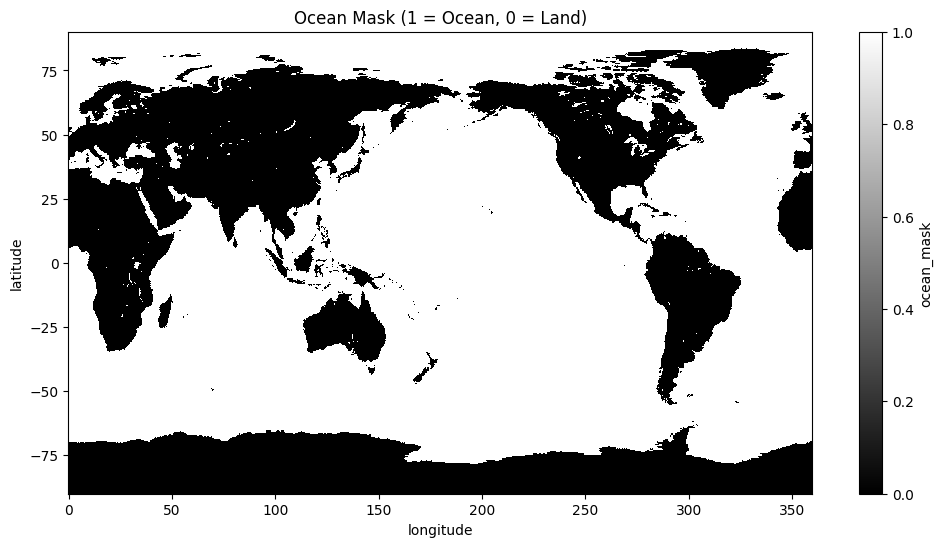

In [3]:
# --- 步骤 1.2: 创建全局海洋掩码 ---
print("\n--- 步骤 1.2: 创建全局海洋掩码 ---\n")

# 调整坐标（反转纬度）

# 检查并反转 latitude 维度 (针对整个加载的数据集，这样train/test的坐标系一致)
if not ds_global_raw[lat_coord_name].to_index().is_monotonic_increasing:
    print(f"纬度坐标 '{lat_coord_name}' 不是单调递增的。将对整个数据集进行反转...")
    ds_global_raw = ds_global_raw.isel({lat_coord_name: slice(None, None, -1)})
    # 重新进行划分，确保train/test数据集也使用反转后的坐标
    ds_test_raw = ds_global_raw.isel({time_coord_name: slice(-num_test_days, None)})
    ds_train_raw = ds_global_raw.isel({time_coord_name: slice(None, -num_test_days)})
    print("整个数据集的纬度已反转，并重新划分了训练/测试集。")
else:
    print(f"纬度坐标 '{lat_coord_name}' 已经是单调递增的。")


data_for_mask_creation = ds_train_raw[sst_var_name].isel({time_coord_name: 0})
global_ocean_mask = (~data_for_mask_creation.isnull()).astype(int)
global_ocean_mask.name = "ocean_mask"
print("全局海洋掩码创建完成。")
print(global_ocean_mask) # 打印掩码的坐标以确认
# 绘制海洋掩码
plt.figure(figsize=(12,6))
global_ocean_mask.plot(cmap='gray')
plt.title('Ocean Mask (1 = Ocean, 0 = Land)')
plt.xlabel(lon_coord_name)
plt.ylabel(lat_coord_name)
plt.show()

步骤 1.3: 计算全局归一化统计量 (仅从训练集)

In [4]:
print("\n--- 步骤 1.3: 计算全局归一化统计量 (仅从训练集) ---\n")
sst_train_ocean_only = ds_train_raw[sst_var_name].where(global_ocean_mask == 1)
mean_sst_train_ocean = sst_train_ocean_only.mean().item()
std_sst_train_ocean = sst_train_ocean_only.std().item()

print(f"训练集海洋区域 SST 全局均值: {mean_sst_train_ocean:.4f}")
print(f"训练集海洋区域 SST 全局标准差: {std_sst_train_ocean:.4f}")

# 保存统计量
normalization_stats = {
    'variable': sst_var_name,
    'mean': mean_sst_train_ocean,
    'std': std_sst_train_ocean
}
save_path_stats = os.path.join(save_era5_dir, f"ERA5_TRAIN_norm_stats_{start_date_full_period_str}_{end_date_full_period_str}_test{num_test_days}days.json")
with open(save_path_stats, 'w') as f:
    json.dump(normalization_stats, f, indent=4)
print(f"归一化统计量已保存到: {save_path_stats}")


--- 步骤 1.3: 计算全局归一化统计量 (仅从训练集) ---

训练集海洋区域 SST 全局均值: 287.2188
训练集海洋区域 SST 全局标准差: 11.6636
归一化统计量已保存到: ../data/processed/ERA5/ERA5_TRAIN_norm_stats_20200101_20200331_test5days.json


步骤 1.4: 时间特征提取与处理 (为整个数据集生成，然后随数据划分)

In [5]:
print("\n--- 步骤 1.4: 时间特征提取与处理 ---\n")

def get_time_features(time_coords_da):
    features = xr.Dataset()
    # 年积日 (Day of Year)
    days_in_year = xr.where(time_coords_da.dt.is_leap_year, 366.0, 365.0)
    doy_normalized = (time_coords_da.dt.dayofyear - 1) / (days_in_year - 1)
    features['doy_sin'] = np.sin(2 * np.pi * doy_normalized)
    features['doy_cos'] = np.cos(2 * np.pi * doy_normalized)
    # 月份 (Month)
    features['month_sin'] = np.sin(2 * np.pi * time_coords_da.dt.month / 12.0)
    features['month_cos'] = np.cos(2 * np.pi * time_coords_da.dt.month / 12.0)
    # 年份 (Year)
    features['year_norm'] = (time_coords_da.dt.year - 2000) / 20.0 # 固定尺度
    # 确保所有特征与原始时间坐标对齐
    for var in features.data_vars:
        features[var] = features[var].assign_coords({time_coord_name: time_coords_da})
    return features


time_features_train_ds = get_time_features(ds_train_raw[time_coord_name])
time_features_test_ds = get_time_features(ds_test_raw[time_coord_name])

print("训练集时间特征 (前5个样本的doy_sin):")
print(time_features_train_ds['doy_sin'].head())
print("测试集时间特征 (所有样本的doy_sin):")
print(time_features_test_ds['doy_sin'])

# 提取出time features list后续用
time_features_to_use = list(time_features_train_ds.data_vars)

# 将时间特征合并到对应的 Dataset 中
ds_train_full_features = xr.merge([ds_train_raw, time_features_train_ds])
ds_test_full_features = xr.merge([ds_test_raw, time_features_test_ds])

print("\n时间特征已提取并合并到训练集和测试集。请检查变量名是否一致！")
print("时间特征包含变量:",time_features_to_use)
print("训练集包含变量:", list(ds_train_full_features.data_vars))
print("测试集包含变量:", list(ds_test_full_features.data_vars))



--- 步骤 1.4: 时间特征提取与处理 ---

训练集时间特征 (前5个样本的doy_sin):
<xarray.DataArray 'doy_sin' (time: 5)> Size: 40B
array([0.        , 0.01721336, 0.03442161, 0.05161967, 0.06880243])
Coordinates:
  * time     (time) datetime64[ns] 40B 2020-01-01 2020-01-02 ... 2020-01-05
测试集时间特征 (所有样本的doy_sin):
<xarray.DataArray 'doy_sin' (time: 5)> Size: 40B
array([0.995919  , 0.99732497, 0.99843542, 0.99925001, 0.9997685 ])
Coordinates:
  * time     (time) datetime64[ns] 40B 2020-03-27 2020-03-28 ... 2020-03-31

时间特征已提取并合并到训练集和测试集。请检查变量名是否一致！
时间特征包含变量: ['doy_sin', 'doy_cos', 'month_sin', 'month_cos', 'year_norm']
训练集包含变量: ['sst', 'doy_sin', 'doy_cos', 'month_sin', 'month_cos', 'year_norm']
测试集包含变量: ['sst', 'doy_sin', 'doy_cos', 'month_sin', 'month_cos', 'year_norm']


步骤 1.5: 图像块处理参数设定

In [6]:
# --- 定义图像块参数  ---
print("\n--- 定义图像块参数 ---")
patch_size_h = 64
patch_size_w = 64
stride_h = 32 # 重叠一半
stride_w = 32 
min_ocean_percentage_in_patch = 0.25 # 至少25%是海洋

print(f"图像块大小: ({patch_size_h}, {patch_size_w})")
print(f"步长: ({stride_h}, {stride_w})")
print(f"图像块最小海洋占比: {min_ocean_percentage_in_patch*100}%")

# --- 创建保存图像块的目录 ---
patch_base_save_dir = os.path.join(save_era5_dir, "patches_sst_daily_precut") # 新的父目录
train_patches_save_dir = os.path.join(patch_base_save_dir, "train")
test_patches_save_dir = os.path.join(patch_base_save_dir, "test")
os.makedirs(train_patches_save_dir, exist_ok=True)
os.makedirs(test_patches_save_dir, exist_ok=True)

# --- 从 normalization_stats 获取均值和标准差 ---
mean_sst = normalization_stats['mean']
std_sst = normalization_stats['std']



--- 定义图像块参数 ---
图像块大小: (64, 64)
步长: (32, 32)
图像块最小海洋占比: 25.0%


1.6 图像分割，处理，保存

In [31]:
# --- 假设之前的代码已运行，我们有：
# ds_train_full_features, ds_test_full_features (xr.Dataset 包含原始SST和所有时间特征)
# global_ocean_mask_sortedcoords (2D xr.DataArray 全局海洋掩码, 坐标已调整)
# normalization_stats (字典，包含训练集海洋SST的 'mean' 和 'std')
# patch_size_h, patch_size_w, stride_h, stride_w, min_ocean_percentage_in_patch
# sst_var_name, lat_coord_name, lon_coord_name, time_coord_name
# train_patches_save_dir, test_patches_save_dir (已创建)
# time_features_to_use (列表，包含要使用的时间特征的名称)
# mean_sst = normalization_stats['mean']
# std_sst = normalization_stats['std']
# ---

import torch # 确保 torch 已导入
import pandas as pd
import xarray as xr
import numpy as np
import os
import glob 

print("\n--- 步骤 1.6: 图像块切割、处理与保存 (输出为 .pt 文件) ---")

DO_SEGMENT = True # 是否启动图像分割任务

def generate_and_save_patches_pt(input_ds,
                                 global_mask_2d,
                                 patch_h, patch_w, stride_h, stride_w,
                                 norm_mean, norm_std,
                                 save_dir, set_name,
                                 sst_var, time_var,
                                 list_of_time_feature_names, # 明确传入时间特征名称列表
                                 min_ocean_pct=0.0
                                 ):
    """
    切割、处理图像块，并将每个块的核心数据保存为 .pt 文件。
    每个 .pt 文件包含一个字典，内有SST张量、掩码张量、坐标数组、时间标识和条件特征张量。
    """
    print(f"\n开始为 '{set_name}' 集生成和保存 .pt 图像块...")
    total_patches_saved = 0
    
    original_sst_da = input_ds[sst_var]
    num_time_steps = len(original_sst_da[time_var])

    for t_idx in range(num_time_steps):
        current_time_value_xr = original_sst_da[time_var].isel({time_var: t_idx})
        # 为了序列化，将 xarray 时间对象转换为更通用的格式
        current_time_pd = pd.to_datetime(str(current_time_value_xr.values))
        current_time_iso_str = current_time_pd.isoformat() # ISO 格式字符串

        print(f"\r  处理 {set_name} 集: 时间步 {t_idx+1}/{num_time_steps} ({current_time_pd.strftime('%Y-%m-%d')})", end="")

        sst_frame = original_sst_da.isel({time_var: t_idx}) 
        
        current_time_features_list = []
        if list_of_time_feature_names:
            for tf_name in list_of_time_feature_names:
                if tf_name in input_ds:
                    # .item() 用于从0维DataArray或单元素数组中获取标量值
                    current_time_features_list.append(input_ds[tf_name].isel({time_var: t_idx}).item())
                else:
                    print(f"\n警告: 时间特征 '{tf_name}' 未在输入 Dataset ({set_name}) 的时间步 {t_idx} 中找到。")
                    current_time_features_list.append(0.0) # 或者其他默认值

        frame_h = sst_frame.sizes[lat_coord_name]
        frame_w = sst_frame.sizes[lon_coord_name]

        num_y_patches = (frame_h - patch_h) // stride_h + 1
        num_x_patches = (frame_w - patch_w) // stride_w + 1

        for r_idx in range(num_y_patches):
            for c_idx in range(num_x_patches):
                y_start = r_idx * stride_h
                y_end = y_start + patch_h
                x_start = c_idx * stride_w
                x_end = x_start + patch_w

                sst_patch_raw_xr = sst_frame.isel({lat_coord_name: slice(y_start, y_end), 
                                                   lon_coord_name: slice(x_start, x_end)}) 
                
                mask_patch_xr = global_mask_2d.sel({lat_coord_name: sst_patch_raw_xr[lat_coord_name], 
                                                    lon_coord_name: sst_patch_raw_xr[lon_coord_name]})

                if min_ocean_pct > 0:
                    ocean_pixel_count = mask_patch_xr.sum().item()
                    if (ocean_pixel_count / mask_patch_xr.size) < min_ocean_pct:
                        continue
                
                sst_patch_normalized_xr = (sst_patch_raw_xr - norm_mean) / norm_std
                sst_patch_final_xr = sst_patch_normalized_xr.where(mask_patch_xr == 1, 0.0)
                
                # 转换为 PyTorch 张量或 NumPy 数组以供保存
                sst_tensor_patch = torch.from_numpy(sst_patch_final_xr.data).float().unsqueeze(0) # [1, H_p, W_p]
                mask_tensor_patch = torch.from_numpy(mask_patch_xr.data).float().unsqueeze(0)    # [1, H_p, W_p]
                
                patch_lat_coords_np = sst_patch_final_xr[lat_coord_name].values
                patch_lon_coords_np = sst_patch_final_xr[lon_coord_name].values
                
                conditions_tensor_patch = torch.tensor(current_time_features_list, dtype=torch.float32)

                data_to_save_in_patch_dict = {
                    'sst': sst_tensor_patch,
                    'ocean_mask': mask_tensor_patch,
                    'latitude': patch_lat_coords_np,    # 保存为NumPy数组
                    'longitude': patch_lon_coords_np,   # 保存为NumPy数组
                    'time_iso_str': current_time_iso_str, # 字符串形式的时间戳
                    'conditions': conditions_tensor_patch
                }
                
                filename = f"patch_{set_name}_tidx{t_idx:04d}_y{y_start:03d}_x{x_start:03d}.pt" # 后缀改为 .pt
                patch_save_path = os.path.join(save_dir, filename)
                
                try:
                    torch.save(data_to_save_in_patch_dict, patch_save_path)
                    total_patches_saved += 1
                except Exception as e_save:
                    print(f"\n保存图像块 {filename} 失败: {e_save}")
    
    print(f"\n完成 '{set_name}' 集。总共保存 {total_patches_saved} 个图像块。")
    return total_patches_saved


if DO_SEGMENT:
    # --- 调用函数 ---
    # 确保 time_features_to_use 列表已定义，并且与 ds_train_full_features 中的变量名一致
    # 例如: time_features_to_use = ['doy_sin', 'doy_cos', 'month_sin', 'month_cos', 'year_norm'] 

        # 处理训练集
    num_train_patches = generate_and_save_patches_pt(
        input_ds=ds_train_full_features,
        global_mask_2d=global_ocean_mask,
        patch_h=patch_size_h, patch_w=patch_size_w,
        stride_h=stride_h, stride_w=stride_w,
        norm_mean=mean_sst, norm_std=std_sst,
        save_dir=train_patches_save_dir,
        set_name="train",
        sst_var=sst_var_name,
        time_var=time_coord_name,
        list_of_time_feature_names=time_features_to_use, # 传递时间特征名称列表
        min_ocean_pct=min_ocean_percentage_in_patch
    )

    # 处理测试集
    num_test_patches = generate_and_save_patches_pt(
        input_ds=ds_test_full_features,
        global_mask_2d=global_ocean_mask,
        patch_h=patch_size_h, patch_w=patch_size_w,
        stride_h=stride_h, stride_w=stride_w,
        norm_mean=mean_sst, norm_std=std_sst,
        save_dir=test_patches_save_dir,
        set_name="test",
        sst_var=sst_var_name,
        time_var=time_coord_name,
        list_of_time_feature_names=time_features_to_use, # 传递时间特征名称列表
        min_ocean_pct=min_ocean_percentage_in_patch
    )

    print(f"\n所有 .pt 图像块已处理并保存完毕。训练集块数: {num_train_patches}, 测试集块数: {num_test_patches}")
else:
    print("\n未启用图像块分割功能。若要进行分割任务，请设置 DO_SEGMENT 为 True 以执行图像块处理。")


--- 步骤 1.6: 图像块切割、处理与保存 (输出为 .pt 文件) ---

开始为 'train' 集生成和保存 .pt 图像块...
  处理 train 集: 时间步 86/86 (2020-03-26)
完成 'train' 集。总共保存 61748 个图像块。

开始为 'test' 集生成和保存 .pt 图像块...
  处理 test 集: 时间步 5/5 (2020-03-31)
完成 'test' 集。总共保存 3590 个图像块。

所有 .pt 图像块已处理并保存完毕。训练集块数: 61748, 测试集块数: 3590


1.7 预览分割结果

In [ ]:
# --- 假设之前的脚本部分已成功运行，并生成了 .pt 文件 ---
# train_patches_save_dir, test_patches_save_dir 包含 .pt 文件
# time_features_to_use 列表已定义

import random
import glob
import torch 
import xarray as xr 
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd # 用于解析时间字符串

print("\n--- 步骤1.7: 预览随机选择的已处理 .pt 图像块 ---")

preview_patch_dir = train_patches_save_dir # 或 test_patches_save_dir
num_previews = 4
print_first_patch_dict_structure = True # 是否打印第一个加载的字典结构

all_patch_files_pt = glob.glob(os.path.join(preview_patch_dir, "*.pt")) # 查找 .pt 文件

if not all_patch_files_pt:
    print(f"警告: 在目录 {preview_patch_dir} 中没有找到 .pt 图像块文件，无法进行预览。")
else:
    files_to_preview_pt = random.sample(all_patch_files_pt, min(num_previews, len(all_patch_files_pt)))
    
    print(f"将预览以下 {len(files_to_preview_pt)} 个 .pt 图像块文件:")
    for f_path in files_to_preview_pt:
        print(f"  - {os.path.basename(f_path)}")

    if print_first_patch_dict_structure and files_to_preview_pt:
        first_pt_file_path = files_to_preview_pt[0]
        print(f"\n--- 字典结构 for: {os.path.basename(first_pt_file_path)} ---")
        try:
            loaded_dict = torch.load(first_pt_file_path,weights_only=False)
            print("加载的字典键:", list(loaded_dict.keys()))
            for key, value in loaded_dict.items():
                if isinstance(value, torch.Tensor):
                    print(f"  - {key}: Tensor, shape={value.shape}, dtype={value.dtype}")
                elif isinstance(value, np.ndarray):
                    print(f"  - {key}: NumPy array, shape={value.shape}, dtype={value.dtype}")
                else:
                    print(f"  - {key}: {type(value)}, value='{value}'")
        except Exception as e:
            print(f"加载或打印文件 {first_pt_file_path} 信息时出错: {e}")

    fig_pt, axes_pt = plt.subplots(nrows=len(files_to_preview_pt), ncols=2, 
                                   figsize=(12, 5 * len(files_to_preview_pt)))
    if len(files_to_preview_pt) == 1:
        axes_pt = np.array([axes_pt]).reshape(1, 2)
    elif len(files_to_preview_pt) == 0:
        pass # No files to plot
    
    for i, patch_file_path in enumerate(files_to_preview_pt):
        if len(files_to_preview_pt) == 0: break # No files, skip plotting loop
        try:
            loaded_data = torch.load(patch_file_path,weights_only=False)
            
            sst_tensor = loaded_data['sst']         # [1, H_p, W_p]
            mask_tensor = loaded_data['ocean_mask'] # [1, H_p, W_p]
            lats_np = loaded_data['latitude']       # [H_p]
            lons_np = loaded_data['longitude']      # [W_p]
            time_str = loaded_data['time_iso_str']
            conditions_np = loaded_data['conditions'].numpy() # [num_time_features]

            # 为了方便使用xarray绘图，临时转换回DataArray
            sst_patch_xr = xr.DataArray(
                sst_tensor.squeeze(0).cpu().numpy(), # 移除channel维，转到CPU, 转到numpy
                coords={lat_coord_name: lats_np, lon_coord_name: lons_np},
                dims=[lat_coord_name, lon_coord_name]
            )
            mask_patch_xr = xr.DataArray(
                mask_tensor.squeeze(0).cpu().numpy(),
                coords={lat_coord_name: lats_np, lon_coord_name: lons_np},
                dims=[lat_coord_name, lon_coord_name]
            )
            
            # 构建时间特征显示字符串
            time_features_str_parts = []
            if time_features_to_use: # 确保列表已定义
                 for idx_tf, tf_name in enumerate(time_features_to_use):
                    if idx_tf < len(conditions_np):
                        time_features_str_parts.append(f"{tf_name}: {conditions_np[idx_tf]:.2f}")
                    else:
                        time_features_str_parts.append(f"{tf_name}: N/A")


            # 绘制SST
            ax_sst = axes_pt[i, 0]
            sst_patch_xr.plot(ax=ax_sst, cmap='coolwarm', robust=True, add_colorbar=True)
            title_str_sst = f"SST: {os.path.basename(patch_file_path)}\nTime: {time_str}\n"
            title_str_sst += "\n".join([", ".join(time_features_str_parts[j:j+2]) for j in range(0, len(time_features_str_parts), 2)])

            ax_sst.set_title(title_str_sst.strip(), fontsize=7) # 减小字号
            ax_sst.set_xlabel("Longitude")
            ax_sst.set_ylabel("Latitude")

            # 绘制掩码
            ax_mask = axes_pt[i, 1]
            mask_patch_xr.plot(ax=ax_mask, cmap='gray', add_colorbar=False)
            ax_mask.set_title(f"Mask: {os.path.basename(patch_file_path)}", fontsize=8)
            ax_mask.set_xlabel("Longitude")
            ax_mask.set_ylabel("Latitude")
                
        except Exception as e:
            print(f"预览或绘制 .pt 文件 {patch_file_path} 时出错: {e}")
            if len(files_to_preview_pt) > 0:
                axes_pt[i,0].set_title(f"Error loading {os.path.basename(patch_file_path)}", fontsize=8)
                axes_pt[i,1].set_title("")
                axes_pt[i,0].axis('off')
                axes_pt[i,1].axis('off')

    if len(files_to_preview_pt) > 0:
        plt.tight_layout()
        plt.show()
    else:
        print("没有 .pt 文件可供预览图像。")


--- 步骤1.7: 预览随机选择的已处理 .pt 图像块 ---
将预览以下 4 个 .pt 图像块文件:
  - patch_train_tidx0054_y576_x864.pt
  - patch_train_tidx0025_y192_x192.pt
  - patch_train_tidx0049_y288_x480.pt
  - patch_train_tidx0038_y512_x640.pt

--- 字典结构 for: patch_train_tidx0054_y576_x864.pt ---
加载的字典键: ['sst', 'ocean_mask', 'latitude', 'longitude', 'time_iso_str', 'conditions']
  - sst: Tensor, shape=torch.Size([1, 64, 64]), dtype=torch.float32
  - ocean_mask: Tensor, shape=torch.Size([1, 64, 64]), dtype=torch.float32
  - latitude: NumPy array, shape=(64,), dtype=float32
  - longitude: NumPy array, shape=(64,), dtype=float32
  - time_iso_str: <class 'str'>, value='2020-02-24T00:00:00'
  - conditions: Tensor, shape=torch.Size([5]), dtype=torch.float32


# 阶段二：构建基于“预切割图像块”的 PyTorch Dataset 和 DataLoader

步骤 2.1：实现 PreCutPatchOceanDataset 类

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import glob # 用于查找文件
import numpy as np # 如果需要处理从 .pt 加载的 numpy 数组 (尽管我们目标是tensor)
import pandas as pd # 用于可能的时间戳转换，如果需要的话

# --- 确保之前的相关变量名可用 ---
# 例如: train_patches_save_dir, test_patches_save_dir (来自阶段一)
# 你在 .pt 文件中保存的字典的键名是固定的，例如 'sst', 'ocean_mask', 'conditions'等

print("\n--- 阶段二：构建 Dataset 和 DataLoader ---")
print("\n--- 步骤 2.1: 实现 PreCutPatchOceanDataset 类 ---")

class PreCutPatchOceanDataset(Dataset):
    def __init__(self, patch_dir):
        """
        Args:
            patch_dir (str): 存放预切割图像块 .pt 文件的目录路径。
        """
        super().__init__()
        self.patch_dir = patch_dir

        # 扫描目录获取所有 .pt 文件路径，并排序以保证可复现性
        self.patch_files = sorted(glob.glob(os.path.join(self.patch_dir, "*.pt")))
        
        if not self.patch_files:
            raise FileNotFoundError(f"在目录 {self.patch_dir} 中没有找到 .pt 文件。请检查路径和文件扩展名。")

        print(f"在 {self.patch_dir} 中找到 {len(self.patch_files)} 个图像块文件。")
        # 打印前几个文件以供检查 
        print("检查前3个文件:", [os.path.basename(f) for f in self.patch_files[:3]])

    def __len__(self):
        """返回数据集中样本的总数 (即图像块文件的数量)。"""
        return len(self.patch_files)

    def __getitem__(self, idx):
        """
        根据索引 idx 加载单个预切割的图像块 .pt 文件。
        返回一个字典，包含SST图像块、海洋掩码块和条件特征。
        """
        patch_file_path = self.patch_files[idx]
        
        try:
            # 使用 torch.load 加载 .pt 文件
            # 关键：由于我们保存了NumPy数组(latitude, longitude)，需要设置 weights_only=False
            loaded_patch_data = torch.load(patch_file_path, weights_only=False) 
            
            sst_tensor = loaded_patch_data['sst']              # 已经是 Tensor [1, H_patch, W_patch]
            mask_tensor = loaded_patch_data['ocean_mask']      # 已经是 Tensor [1, H_patch, W_patch]
            conditions_tensor = loaded_patch_data['conditions']# 已经是 Tensor [num_conditions]
            
            # 先提取坐标和时间戳信息，可以方便后续需要
            # 但对于模型训练的核心输入，通常只需要SST, mask, conditions。
            lat_coords = loaded_patch_data['latitude']      # NumPy array
            lon_coords = loaded_patch_data['longitude']     # NumPy array
            time_iso_str = loaded_patch_data['time_iso_str'] # str
            
        except Exception as e:
            print(f"加载或处理文件 {patch_file_path} 时出错: {e}")
            # 在实际训练中，你可能希望返回一个虚拟/损坏的样本，或者跳过它，
            # 而不是让整个训练过程崩溃。但为了调试，先重新抛出异常。
            raise e

        return {
            'sst': sst_tensor,
            'ocean_mask': mask_tensor,
            'conditions': conditions_tensor,
            # 训练可能不会用到的features
            'latitude_coords': torch.from_numpy(lat_coords).float(), 
            'longitude_coords': torch.from_numpy(lon_coords).float(),
            'time_identifier': time_iso_str 
        }

print("PreCutPatchOceanDataset 类定义完成。")


--- 阶段二：构建 Dataset 和 DataLoader ---

--- 步骤 2.1: 实现 PreCutPatchOceanDataset 类 ---
PreCutPatchOceanDataset 类定义完成。


步骤 2.2：创建 DataLoader

In [20]:
# --- 假设这些路径和变量名已经定义 ---
# train_patches_save_dir = os.path.join(patch_base_save_dir, "train")
# test_patches_save_dir = os.path.join(patch_base_save_dir, "test")

# TODO:batch_size 
batch_size = 4

print("\n--- 步骤 2.2: 创建 DataLoader ---")

# 1. 为训练集创建 Dataset 和 DataLoader
try:
    print(f"为训练集创建Dataset，从目录: {train_patches_save_dir}")
    train_dataset = PreCutPatchOceanDataset(patch_dir=train_patches_save_dir)
    
    # 只有当dataset非空时才创建dataloader
    if len(train_dataset) > 0:
        train_dataloader = DataLoader(
            train_dataset,
            batch_size=batch_size, # 使用你定义的 batch_size
            shuffle=True,                 # 训练时打乱数据
            num_workers=0,                # Windows下建议为0，Linux下可以尝试增加 (例如 2, 4)
            pin_memory=torch.cuda.is_available() # 如果使用GPU，可以加速内存拷贝
        )
        print(f"训练集 DataLoader 创建成功。样本数: {len(train_dataset)}, 批次大小: {batch_size}, 批次数: {len(train_dataloader)}")
    else:
        print("训练集为空，未创建 DataLoader。")
        train_dataloader = None # 标记为None

except FileNotFoundError as e:
    print(e)
    train_dataloader = None
except Exception as e:
    print(f"创建训练集 DataLoader 时发生意外错误: {e}")
    train_dataloader = None


# 2. 为测试集创建 Dataset 和 DataLoader
try:
    print(f"\n为测试集创建Dataset，从目录: {test_patches_save_dir}")
    test_dataset = PreCutPatchOceanDataset(patch_dir=test_patches_save_dir)

    if len(test_dataset) > 0:
        test_dataloader = DataLoader(
            test_dataset,
            batch_size=batch_size, # 测试时通常也用训练的batch_size，或可以更大
            shuffle=False,                # 测试/验证时不需要打乱
            num_workers=0,
            pin_memory=torch.cuda.is_available()
        )
        print(f"测试集 DataLoader 创建成功。样本数: {len(test_dataset)}, 批次大小: {batch_size}, 批次数: {len(test_dataloader)}")
    else:
        print("测试集为空，未创建 DataLoader。")
        test_dataloader = None
except FileNotFoundError as e:
    print(e)
    test_dataloader = None
except Exception as e:
    print(f"创建测试集 DataLoader 时发生意外错误: {e}")
    test_dataloader = None


# 3. 测试 DataLoader - 迭代一个批次看看输出
if train_dataloader is not None and len(train_dataloader) > 0 :
    print("\n测试 DataLoader - 获取一个训练批次的数据:")
    try:
        # 获取一个迭代器
        data_iter = iter(train_dataloader)
        # 获取第一批数据
        first_batch = next(data_iter)

        sst_batch = first_batch['sst']
        mask_batch = first_batch['ocean_mask']
        conditions_batch = first_batch['conditions']

        print(f"\n第一个训练批次:")
        print(f"  SST 批次形状: {sst_batch.shape}")       # 期望: [batch_size, 1, H_patch, W_patch]
        print(f"  掩码批次形状: {mask_batch.shape}")     # 期望: [batch_size, 1, H_patch, W_patch]
        print(f"  条件批次形状: {conditions_batch.shape}") # 期望: [batch_size, num_time_features]
        
        # 可以打印一些值来检查
        print(f"  SST 示例值 (第一个样本的[0,0,0]点): {sst_batch[0, 0, 0, 0].item()}")
        print(f"  条件示例值 (第一个样本): {conditions_batch[0]}")

    except Exception as e:
        print(f"从 DataLoader 获取数据时出错: {e}")
else:
    print("训练集 DataLoader 未成功创建或为空，跳过 DataLoader 测试。")


--- 步骤 2.2: 创建 DataLoader ---
为训练集创建Dataset，从目录: ../data/processed/ERA5/patches_sst_daily_precut\train
在 ../data/processed/ERA5/patches_sst_daily_precut\train 中找到 61748 个图像块文件。
检查前3个文件: ['patch_train_tidx0000_y000_x736.pt', 'patch_train_tidx0000_y032_x1024.pt', 'patch_train_tidx0000_y032_x1056.pt']
训练集 DataLoader 创建成功。样本数: 61748, 批次大小: 4, 批次数: 15437

为测试集创建Dataset，从目录: ../data/processed/ERA5/patches_sst_daily_precut\test
在 ../data/processed/ERA5/patches_sst_daily_precut\test 中找到 3590 个图像块文件。
检查前3个文件: ['patch_test_tidx0000_y000_x736.pt', 'patch_test_tidx0000_y032_x1024.pt', 'patch_test_tidx0000_y032_x1056.pt']
测试集 DataLoader 创建成功。样本数: 3590, 批次大小: 4, 批次数: 898

测试 DataLoader - 获取一个训练批次的数据:

第一个训练批次:
  SST 批次形状: torch.Size([4, 1, 64, 64])
  掩码批次形状: torch.Size([4, 1, 64, 64])
  条件批次形状: torch.Size([4, 5])
  SST 示例值 (第一个样本的[0,0,0]点): 1.081551432609558
  条件示例值 (第一个样本): tensor([8.8407e-01, 4.6736e-01, 1.0000e+00, 6.1232e-17, 1.0000e+00])


## 阶段三：构建Diffusion Model

In [21]:
# 导入模块
import torch
import torch.nn as nn
import torch.nn.functional as F 
import math # 用于 SinusoidalTimeEmbedding

3.1: 时间步编码器

In [22]:
print("\n--- 阶段三：定义扩散模型组件 ---")

# --- 步骤 3.1: 时间步编码器 ---
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        if self.dim % 2 != 0:
            raise ValueError(f"Embedding dimension (dim={dim}) must be an even number.")

    def forward(self, time_steps): # time_steps: 1D tensor of shape (B,)
        device = time_steps.device
        half_dim = self.dim // 2
        # 准备除数部分：10000^(2i/dim)
        embeddings_scale = torch.exp(torch.arange(half_dim, device=device) * -(math.log(10000) / (half_dim - 1)))
        # embeddings_scale shape: (half_dim,)
        
        # time_steps shape: (B,) -> (B, 1)
        # embeddings_scale shape: (half_dim,) -> (1, half_dim)
        # 结果为 (B, 1) * (1, half_dim) -> (B, half_dim)
        scaled_time = time_steps.unsqueeze(1) * embeddings_scale.unsqueeze(0)
        
        # 计算 sin 和 cos 部分并拼接
        embeddings = torch.cat((scaled_time.sin(), scaled_time.cos()), dim=-1)
        # embeddings shape: (B, dim)
        return embeddings

print("SinusoidalTimeEmbedding 类已定义。")


--- 阶段三：定义扩散模型组件 ---
SinusoidalTimeEmbedding 类已定义。


3.2: 上下文条件编码器

In [23]:
# --- 步骤 3.2: 上下文条件编码器 ---
class ConditionalEmbeddingMLP(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim=None):
        super().__init__()
        if hidden_dim is None:
            hidden_dim = embed_dim # 可以让隐藏层维度与输出嵌入维度相同
        
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(), # SiLU (Swish) 激活函数
            nn.Linear(hidden_dim, embed_dim)
        )

    def forward(self, conditions): # conditions: [B, input_dim]
        return self.mlp(conditions) # Output: [B, embed_dim]

print("ConditionalEmbeddingMLP 类已定义。")

ConditionalEmbeddingMLP 类已定义。


3.3: U-Net 基础构建块

In [24]:
# --- 步骤 3.3: U-Net 基础构建块 ---
class DoubleConv(nn.Module):
    """(Convolution => [GroupNorm] => SiLU) * 2 + Time/Condition Embedding injection"""
    def __init__(self, in_channels, out_channels, mid_channels=None, use_groupnorm=True, num_groups=32,
                 time_emb_dim=None, cond_emb_dim=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        
        self.time_emb_dim = time_emb_dim
        self.cond_emb_dim = cond_emb_dim

        # 第一个卷积 + 归一化
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False)
        self.norm1 = nn.GroupNorm(min(num_groups, mid_channels), mid_channels) if use_groupnorm else nn.BatchNorm2d(mid_channels)
        
        # 线性层用于将嵌入投影到与第一个卷积输出相同的通道数 (mid_channels)
        if self.time_emb_dim is not None:
            self.time_proj1 = nn.Linear(time_emb_dim, mid_channels)
        if self.cond_emb_dim is not None:
            self.cond_proj1 = nn.Linear(cond_emb_dim, mid_channels)
        
        self.act1 = nn.SiLU(inplace=True)

        # 第二个卷积 + 归一化
        self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.norm2 = nn.GroupNorm(min(num_groups, out_channels), out_channels) if use_groupnorm else nn.BatchNorm2d(out_channels)
        
        # 线性层用于将嵌入投影到与第二个卷积输出相同的通道数 (out_channels)
        # (可选: 也可以只在第一个卷积后注入，或者组合嵌入后只投影一次)
        if self.time_emb_dim is not None:
            self.time_proj2 = nn.Linear(time_emb_dim, out_channels)
        if self.cond_emb_dim is not None:
            self.cond_proj2 = nn.Linear(cond_emb_dim, out_channels)
            
        self.act2 = nn.SiLU(inplace=True)

    def forward(self, x, t_emb=None, c_emb=None):
        h = self.conv1(x)
        h = self.norm1(h)

        if t_emb is not None and self.time_emb_dim is not None:
            t_emb_p1 = self.time_proj1(F.silu(t_emb))
            h = h + t_emb_p1.unsqueeze(-1).unsqueeze(-1) # Reshape [B, C] to [B, C, 1, 1]

        if c_emb is not None and self.cond_emb_dim is not None:
            c_emb_p1 = self.cond_proj1(F.silu(c_emb))
            h = h + c_emb_p1.unsqueeze(-1).unsqueeze(-1)
        
        h = self.act1(h)

        h2 = self.conv2(h)
        h2 = self.norm2(h2)

        if t_emb is not None and self.time_emb_dim is not None:
            t_emb_p2 = self.time_proj2(F.silu(t_emb))
            h2 = h2 + t_emb_p2.unsqueeze(-1).unsqueeze(-1)

        if c_emb is not None and self.cond_emb_dim is not None:
            c_emb_p2 = self.cond_proj2(F.silu(c_emb))
            h2 = h2 + c_emb_p2.unsqueeze(-1).unsqueeze(-1)
            
        h2 = self.act2(h2)
        return h2

print("DoubleConv 类已定义。")

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels, use_groupnorm=True, time_emb_dim=None, cond_emb_dim=None):
        super().__init__()
        self.maxpool = nn.MaxPool2d(2)
        self.double_conv = DoubleConv(in_channels, out_channels, use_groupnorm=use_groupnorm, 
                                      time_emb_dim=time_emb_dim, cond_emb_dim=cond_emb_dim)

    def forward(self, x, t_emb=None, c_emb=None):
        x_pooled = self.maxpool(x)
        return self.double_conv(x_pooled, t_emb, c_emb)

print("Down 类已定义。")

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels_deep, skip_channels, out_channels_block, 
                 bilinear=True, use_groupnorm=True, time_emb_dim=None, cond_emb_dim=None):
        super().__init__()
        
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            # 对于bilinear上采样，in_channels_deep 就是上采样后的通道数
            # mid_channels_for_conv 通常基于 out_channels_block
            self.conv = DoubleConv(in_channels_deep + skip_channels, out_channels_block, 
                                   mid_channels=out_channels_block, # 或者 (in_channels_deep + skip_channels) // 2
                                   use_groupnorm=use_groupnorm, 
                                   time_emb_dim=time_emb_dim, cond_emb_dim=cond_emb_dim)
        else:
            # ConvTranspose2d 通常将 in_channels_deep 转换为 out_channels_block 或 skip_channels
            # 这里我们假设它将 in_channels_deep 转换为 skip_channels，以便与跳跃连接的通道数匹配
            self.up = nn.ConvTranspose2d(in_channels_deep, skip_channels, kernel_size=2, stride=2)
            self.conv = DoubleConv(skip_channels + skip_channels, out_channels_block, 
                                   mid_channels=out_channels_block,
                                   use_groupnorm=use_groupnorm,
                                   time_emb_dim=time_emb_dim, cond_emb_dim=cond_emb_dim)

    def forward(self, x1_deep, x2_skip, t_emb=None, c_emb=None): # x1_deep from deeper layer, x2_skip from encoder
        x1_upsampled = self.up(x1_deep)

        # Pad x1_upsampled to match x2_skip spatial dimensions if necessary
        diffY = x2_skip.size()[2] - x1_upsampled.size()[2]
        diffX = x2_skip.size()[3] - x1_upsampled.size()[3]

        x1_upsampled = F.pad(x1_upsampled, [diffX // 2, diffX - diffX // 2,
                                           diffY // 2, diffY - diffY // 2])
        
        x_concatenated = torch.cat([x2_skip, x1_upsampled], dim=1)
        return self.conv(x_concatenated, t_emb, c_emb)

print("Up 类已定义。")

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

print("OutConv 类已定义。")

class UNet(nn.Module):
    def __init__(self, n_channels_in, n_channels_out, 
                 time_embedding_dim, cond_embedding_dim=0, # cond_embedding_dim 可以为0
                 base_c=64, bilinear=True, use_groupnorm=True):
        super().__init__()
        self.n_channels_in = n_channels_in
        self.n_channels_out = n_channels_out
        self.time_embedding_dim = time_embedding_dim
        self.cond_embedding_dim = cond_embedding_dim
        self.base_c = base_c # 保存 base_c 以便外部访问

        # Encoder
        self.inc = DoubleConv(n_channels_in, base_c, use_groupnorm=use_groupnorm, 
                              time_emb_dim=time_embedding_dim, cond_emb_dim=cond_embedding_dim)
        self.down1 = Down(base_c, base_c * 2, use_groupnorm=use_groupnorm, 
                          time_emb_dim=time_embedding_dim, cond_emb_dim=cond_embedding_dim)
        self.down2 = Down(base_c * 2, base_c * 4, use_groupnorm=use_groupnorm, 
                          time_emb_dim=time_embedding_dim, cond_emb_dim=cond_embedding_dim)
        self.down3 = Down(base_c * 4, base_c * 8, use_groupnorm=use_groupnorm, 
                          time_emb_dim=time_embedding_dim, cond_emb_dim=cond_embedding_dim)
        
        # 瓶颈因子 factor ，通常情况下，如果 bilinear=False，ConvTranspose 可能会在 Up 模块的 DoubleConv 之前将通道数减半。
        # 原始的UNet 设计中 bilinear=False
        self.down4 = Down(base_c * 8, base_c * 16, use_groupnorm=use_groupnorm, 
                          time_emb_dim=time_embedding_dim, cond_emb_dim=cond_embedding_dim) # Bottleneck

        # Decoder
        # Up(in_channels_deep, skip_channels, out_channels_block, ...)
        self.up1 = Up(base_c * 16, base_c * 8, base_c * 8, bilinear, use_groupnorm, time_embedding_dim, cond_embedding_dim)
        self.up2 = Up(base_c * 8,  base_c * 4, base_c * 4, bilinear, use_groupnorm, time_embedding_dim, cond_embedding_dim)
        self.up3 = Up(base_c * 4,  base_c * 2, base_c * 2, bilinear, use_groupnorm, time_embedding_dim, cond_embedding_dim)
        self.up4 = Up(base_c * 2,  base_c,     base_c,     bilinear, use_groupnorm, time_embedding_dim, cond_embedding_dim)
        self.outc = OutConv(base_c, n_channels_out)

    def forward(self, x_in, t_emb, c_emb=None): # 接收时间步和条件嵌入
        # x_in: [B, C_in, H, W]
        # t_emb: [B, time_embedding_dim]
        # c_emb: [B, cond_embedding_dim] or None

        # Encoder
        x1 = self.inc(x_in, t_emb, c_emb)    # [B, base_c, H, W]
        x2 = self.down1(x1, t_emb, c_emb)  # [B, base_c*2, H/2, W/2]
        x3 = self.down2(x2, t_emb, c_emb)  # [B, base_c*4, H/4, W/4]
        x4 = self.down3(x3, t_emb, c_emb)  # [B, base_c*8, H/8, W/8]
        x5 = self.down4(x4, t_emb, c_emb)  # [B, base_c*16, H/16, W/16] (bottleneck)

        # Decoder
        x = self.up1(x5, x4, t_emb, c_emb) # x5 from deep, x4 is skip. Output: [B, base_c*8, H/8, W/8]
        x = self.up2(x, x3, t_emb, c_emb)  # Output: [B, base_c*4, H/4, W/4]
        x = self.up3(x, x2, t_emb, c_emb)  # Output: [B, base_c*2, H/2, W/2]
        x = self.up4(x, x1, t_emb, c_emb)  # Output: [B, base_c, H, W]
        logits = self.outc(x)              # Output: [B, n_channels_out, H, W]
        return logits

print("UNet 类已定义。")

DoubleConv 类已定义。
Down 类已定义。
Up 类已定义。
OutConv 类已定义。
UNet 类已定义。


3.4 实例化模型并测试

In [25]:
# --- 步骤3.4：实例化模型组件并测试 ---

# 0. 设备配置 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n将使用设备: {device}")

# 1. 从 DataLoader 获取样本批次以确定输入维度
C_in = -1
H_patch = -1
W_patch = -1
num_context_features = -1
_B = -1 # 批次大小

if 'train_dataloader' in locals() and train_dataloader is not None and len(train_dataloader) > 0:
    try:
        sample_batch = next(iter(train_dataloader))
        example_sst_batch = sample_batch['sst']
        example_conditions_batch = sample_batch['conditions']
        
        _B, C_in, H_patch, W_patch = example_sst_batch.shape
        if example_conditions_batch.ndim == 2:
            num_context_features = example_conditions_batch.shape[1]
        elif example_conditions_batch.numel() == 0:
             num_context_features = 0
        else:
            print(f"警告: 条件批次形状 {example_conditions_batch.shape} 未被预期。")
            num_context_features = 0 # 或根据情况调整

        print(f"从 DataLoader 获取的样本批次信息:")
        print(f"  SST 形状 (B, C, H, W): ({_B}, {C_in}, {H_patch}, {W_patch})")
        print(f"  条件形状 (B, N_features): ({example_conditions_batch.shape[0]}, {num_context_features if num_context_features > 0 else 'N/A'})")
    except StopIteration:
        print("错误: train_dataloader 为空。请确保它有数据。")
        exit()
    except Exception as e:
        print(f"从 DataLoader 获取样本时发生错误: {e}")
        exit()
else:
    print("错误: train_dataloader 未定义或为空。")
    exit()

# 2. 实例化时间步编码器
time_embedding_dim = 128 
time_embed_module = SinusoidalTimeEmbedding(dim=time_embedding_dim).to(device)
print(f"时间步编码器实例化完成。嵌入维度: {time_embedding_dim}")

# 3. 实例化上下文条件编码器
cond_embedding_dim = 128 
actual_cond_emb_dim_for_unet = 0 # U-Net中cond_embedding_dim的实际值
if num_context_features > 0:
    cond_embed_module = ConditionalEmbeddingMLP(
        input_dim=num_context_features, 
        embed_dim=cond_embedding_dim
    ).to(device)
    actual_cond_emb_dim_for_unet = cond_embedding_dim
    print(f"上下文条件编码器实例化完成。输入维度: {num_context_features}, 嵌入维度: {cond_embedding_dim}")
else:
    cond_embed_module = None
    print("未使用上下文条件编码器。")

# 4. 实例化 U-Net 模型
unet_model = UNet(
    n_channels_in=C_in,
    n_channels_out=C_in, 
    time_embedding_dim=time_embedding_dim,
    cond_embedding_dim=actual_cond_emb_dim_for_unet, 
    base_c=32, # 你可以根据需要调整
    bilinear=True,
    use_groupnorm=True 
).to(device)
print(f"U-Net 模型实例化完成。基础通道数 (base_c): {unet_model.base_c}")
total_params = sum(p.numel() for p in unet_model.parameters() if p.requires_grad)
print(f"U-Net 模型总可训练参数数量: {total_params:,}")

# 5. 测试模型前向传播
print("\n测试模型前向传播...")
try:
    dummy_timesteps = torch.randint(0, 1000, (_B,), device=device).long() # 模拟时间步
    t_emb = time_embed_module(dummy_timesteps)
    
    c_emb = None
    if cond_embed_module is not None and example_conditions_batch.numel() > 0:
        c_emb = cond_embed_module(example_conditions_batch.to(device))

    noisy_images_sample = example_sst_batch.to(device)

    with torch.no_grad():
        predicted_noise = unet_model(noisy_images_sample, t_emb, c_emb)
    
    print(f"U-Net 输入 (带噪图像) 形状: {noisy_images_sample.shape}")
    print(f"时间步嵌入形状: {t_emb.shape}")
    if c_emb is not None:
        print(f"上下文条件嵌入形状: {c_emb.shape}")
    print(f"U-Net 输出 (预测噪声) 形状: {predicted_noise.shape}")

    if predicted_noise.shape == noisy_images_sample.shape:
        print("模型前向传播测试成功，输入输出形状一致！")
    else:
        print("警告：模型输出形状与输入形状不一致！")
        
except Exception as e:
    print(f"模型前向传播测试时发生错误: {e}")
    import traceback
    traceback.print_exc()


将使用设备: cuda
从 DataLoader 获取的样本批次信息:
  SST 形状 (B, C, H, W): (4, 1, 64, 64)
  条件形状 (B, N_features): (4, 5)
时间步编码器实例化完成。嵌入维度: 128
上下文条件编码器实例化完成。输入维度: 5, 嵌入维度: 128
U-Net 模型实例化完成。基础通道数 (base_c): 32
U-Net 模型总可训练参数数量: 8,608,577

测试模型前向传播...
U-Net 输入 (带噪图像) 形状: torch.Size([4, 1, 64, 64])
时间步嵌入形状: torch.Size([4, 128])
上下文条件嵌入形状: torch.Size([4, 128])
U-Net 输出 (预测噪声) 形状: torch.Size([4, 1, 64, 64])
模型前向传播测试成功，输入输出形状一致！


## 模块四：训练逻辑

步骤 4.1: 训练环境与核心参数定义

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F # 确保导入
import torch.optim as optim
import os
import numpy as np
import pandas as pd # 可能会在加载或文件名处理时用到
import math # 用于SinusoidalTimeEmbedding

# --- 假设之前的脚本部分已定义并可用 ---
# train_dataloader, test_dataloader (已创建，这里主要用train_dataloader)
# SinusoidalTimeEmbedding, ConditionalEmbeddingMLP, UNet 类定义
# save_era5_dir, start_date_full_period_str, end_date_full_period_str (用于文件名)
# normalization_stats (字典，包含mean和std)
# time_features_to_use (列表，包含时间特征名称)
# patch_size_h, patch_size_w (图像块尺寸)
# --- -------------------------------- ---

print("\n--- 阶段四：实现训练逻辑 ---")
print("--- 步骤 4.1: 训练环境与核心参数定义 ---")

# 设备配置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"将使用设备: {device}")

# 扩散过程超参数 
T = 100  # 总的扩散步数 (例如 200, 1000, 2000)
beta_start = 0.0001
beta_end = 0.02

# betas 定义了每一步添加噪声的方差。这里使用线性调度。
betas = torch.linspace(beta_start, beta_end, T, device=device)

print(f"总扩散步数 T: {T}")
print(f"Beta 调度: 线性, 从 {beta_start} 到 {beta_end}")
print(f"Betas 张量形状: {betas.shape}, 设备: {betas.device}")

# 辅助过程
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)  
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0) 

# 前向过程 q(x_t | x_0) 所需的系数: x_t = sqrt_alphas_cumprod * x_0 + sqrt_one_minus_alphas_cumprod * noise
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# (可选) 用于DDPM采样器的后验分布 q(x_{t-1} | x_t, x_0) 的方差
# posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)
# 对于直接预测噪声的模型，这个在训练时不是必须的，主要用于采样。

print(f"Alphas 形状: {alphas.shape}")
print(f"Alphas_cumprod 形状: {alphas_cumprod.shape}")
print(f"Sqrt_alphas_cumprod 形状: {sqrt_alphas_cumprod.shape}")
print(f"Sqrt_one_minus_alphas_cumprod 形状: {sqrt_one_minus_alphas_cumprod.shape}")


--- 阶段四：实现训练逻辑 ---
--- 步骤 4.1: 训练环境与核心参数定义 ---
将使用设备: cuda
总扩散步数 T: 1000
Beta 调度: 线性, 从 0.0001 到 0.02
Betas 张量形状: torch.Size([1000]), 设备: cuda:0
Alphas 形状: torch.Size([1000])
Alphas_cumprod 形状: torch.Size([1000])
Sqrt_alphas_cumprod 形状: torch.Size([1000])
Sqrt_one_minus_alphas_cumprod 形状: torch.Size([1000])


步骤 4.2: 模型组件、损失函数与优化器实例化

In [ ]:
# --- 假设之前的代码 (步骤 4.1 及更早的) 已经成功运行 ---
# device, T, betas, alphas, alphas_cumprod, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod
# SinusoidalTimeEmbedding, ConditionalEmbeddingMLP, UNet 类定义
# train_dataloader
# time_features_to_use (列表，包含时间特征名称，用于确定num_context_features)
# patch_size_h, patch_size_w (用于在DataLoader不可用时的备用维度)
# --- ---------------------------------------------------- ---

print("\n--- 步骤 4.2: 模型组件、损失函数与优化器实例化 ---")

# 1. 从 DataLoader 获取样本批次以确定输入维度
#    这确保模型参数与数据维度精确匹配。
C_in = -1
H_patch = -1 # 图像块高度
W_patch = -1 # 图像块宽度
num_context_features = -1
actual_batch_size = -1

if 'train_dataloader' in locals() and train_dataloader is not None and len(train_dataloader) > 0:
    try:
        sample_batch_for_dims = next(iter(train_dataloader))
        example_sst_batch = sample_batch_for_dims['sst']
        example_conditions_batch = sample_batch_for_dims['conditions']
        
        actual_batch_size, C_in, H_patch, W_patch = example_sst_batch.shape
        
        if example_conditions_batch.ndim == 2:
            num_context_features = example_conditions_batch.shape[1]
        elif example_conditions_batch.numel() == 0: # 空的条件张量
             num_context_features = 0
        else:
            print(f"警告: 条件批次形状 {example_conditions_batch.shape} 未被预期。将上下文特征数设为0。")
            num_context_features = 0

        print(f"从 DataLoader 获取的维度信息:")
        print(f"  SST 形状 (B, C, H, W): ({actual_batch_size}, {C_in}, {H_patch}, {W_patch})")
        print(f"  条件特征数量: {num_context_features if num_context_features > 0 else '无'}")

    except StopIteration:
        print("错误: train_dataloader 为空。请确保它有数据。")
        # 作为备用，你可以使用之前定义的全局变量 patch_size_h, patch_size_w
        # C_in = 1 # 假设SST是单通道
        # H_patch, W_patch = patch_size_h, patch_size_w # 使用全局定义的patch大小
        # num_context_features = len(time_features_to_use) # 使用全局定义的时间特征列表长度
        # print(f"警告: 使用预定义的维度: C_in={C_in}, H_patch={H_patch}, W_patch={W_patch}, N_features={num_context_features}")
        exit() # 最好是停止，因为数据加载是前提
    except Exception as e:
        print(f"从 DataLoader 获取样本维度时发生错误: {e}")
        exit()
else:
    print("错误: train_dataloader 未定义或为空。无法确定模型输入维度。")
    exit()


# 2. 实例化时间步编码器
time_embedding_dim = 128  # 嵌入向量的维度，可以调整 (例如 128, 256)
time_embed_module = SinusoidalTimeEmbedding(dim=time_embedding_dim).to(device)
print(f"时间步编码器 (SinusoidalTimeEmbedding) 实例化完成。嵌入维度: {time_embedding_dim}")

# 3. 实例化上下文条件编码器
cond_embedding_dim = 128  # 嵌入向量的维度，可以调整
actual_cond_emb_dim_for_unet = 0 # U-Net中cond_embedding_dim的实际值

if num_context_features > 0:
    cond_embed_module = ConditionalEmbeddingMLP(
        input_dim=num_context_features, 
        embed_dim=cond_embedding_dim
    ).to(device)
    actual_cond_emb_dim_for_unet = cond_embedding_dim
    print(f"上下文条件编码器 (ConditionalEmbeddingMLP) 实例化完成。输入维度: {num_context_features}, 嵌入维度: {cond_embedding_dim}")
else:
    cond_embed_module = None
    print("未使用上下文条件编码器 (因为 num_context_features 为 0)。")

# 4. 实例化 U-Net 模型
# 我们将遵循原始U-Net设计，使用转置卷积进行上采样 (bilinear=False)
unet_model = UNet(
    n_channels_in=C_in,    # 从数据加载器获取的SST图像块通道数 (应为1)
    n_channels_out=C_in,   # 模型预测噪声，与输入SST通道数相同
    time_embedding_dim=time_embedding_dim,
    cond_embedding_dim=actual_cond_emb_dim_for_unet, # 如果无条件，则为0
    base_c=4,             # U-Net基础通道数 (例如 16, 32, 64) - 根据显存调整
    bilinear=True,        # 若设为 False 以使用转置卷积，则遵从原始U-Net设计
    use_groupnorm=True     # 是否使用GroupNorm
).to(device)


print(f"U-Net 模型实例化完成。基础通道数 (base_c): {unet_model.base_c if hasattr(unet_model, 'base_c') else '未指定'}") 
total_params = sum(p.numel() for p in unet_model.parameters() if p.requires_grad)
print(f"U-Net 模型总可训练参数数量: {total_params:,}")


# 5. 定义损失函数
# 我们预测的是噪声，所以用 MSELoss 比较预测噪声和真实噪声
# reduction='none' 这使得损失函数返回每个像素点的损失，而不是直接返回一个标量的平均损失，以便后续我们可以手动应用海洋掩码，然后计算平均损失
loss_fn = nn.MSELoss(reduction='none') 
print(f"损失函数 (MSELoss, reduction='none') 定义完成。")

# 6. 定义优化器
learning_rate = 1e-4 # 初始学习率，可以调整
optimizer = optim.AdamW(unet_model.parameters(), lr=learning_rate)
# 如果 cond_embed_module 也有可学习参数 (MLP是有的)，也应加入优化器
if cond_embed_module is not None:
    optimizer_params = list(unet_model.parameters()) + list(cond_embed_module.parameters())
    optimizer = optim.AdamW(optimizer_params, lr=learning_rate)
    print(f"优化器 (AdamW) 定义完成，包含U-Net和条件编码器参数。学习率: {learning_rate}")
else:
    print(f"优化器 (AdamW) 定义完成，仅包含U-Net参数。学习率: {learning_rate}")


--- 步骤 4.2: 模型组件、损失函数与优化器实例化 ---
从 DataLoader 获取的维度信息:
  SST 形状 (B, C, H, W): (4, 1, 64, 64)
  条件特征数量: 5
时间步编码器 (SinusoidalTimeEmbedding) 实例化完成。嵌入维度: 128
上下文条件编码器 (ConditionalEmbeddingMLP) 实例化完成。输入维度: 5, 嵌入维度: 128
U-Net 模型实例化完成。基础通道数 (base_c): 32
U-Net 模型总可训练参数数量: 8,522,017
损失函数 (MSELoss, reduction='none') 定义完成。
优化器 (AdamW) 定义完成，包含U-Net和条件编码器参数。学习率: 0.0001


步骤 4.3: 核心训练循环

In [30]:
# --- 假设之前的代码 (步骤 4.1, 4.2 及更早的) 已经成功运行 ---
# device, T, betas, alphas, alphas_cumprod, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod
# time_embed_module, cond_embed_module (可能为None), unet_model
# loss_fn (reduction='none'), optimizer
# train_dataloader (dataloader for training patches)
# save_era5_dir, start_date_full_period_str, end_date_full_period_str (用于文件名)
# normalization_stats (用于保存到checkpoint)
# time_embedding_dim, cond_embedding_dim, num_context_features (用于保存到checkpoint)
# C_in (输入通道数，来自dataloader，用于保存到checkpoint)
# --- -------------------------------------------------------------------- ---
from tqdm import tqdm
print("\n--- 步骤 4.3: 核心训练循环 ---")

num_epochs = 10 # 训练的总轮数 (重要超参数，初始可以设小一点测试，例如5-20)
log_interval = 500 # 每隔多少个batch打印一次日志
save_interval = 10 # 每隔多少个epoch保存一次模型
# 模型保存位置
model_checkpoint_save_path = "checkpoints" # 创建一个子目录保存模型
os.makedirs(model_checkpoint_save_path, exist_ok=True)

# 辅助函数，用于从预计算的调度表中提取特定时间步 t 的值
def extract(a_scheduler_array, t_timesteps, x_shape):
    # a_scheduler_array: e.g., sqrt_alphas_cumprod (1D tensor on device)
    # t_timesteps: batch of timesteps (1D tensor on device)
    # x_shape: shape of the image batch [B, C, H, W]
    batch_size = t_timesteps.shape[0]
    # 使用 t_timesteps 作为索引从 a_scheduler_array 中 gather 值
    out = a_scheduler_array.gather(-1, t_timesteps)
    # 将 out 从 [B] 重塑为 [B, 1, 1, 1] 以便与图像批次广播
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))

# --- 开始训练 ---
# 确保所有模型组件都在正确的设备上，并且处于训练模式
unet_model.to(device).train()
time_embed_module.to(device).train() # 通常无参数，但规范起见
if cond_embed_module is not None:
    cond_embed_module.to(device).train()

# 预先将调度器变量移到device，避免在循环中重复移动
sqrt_alphas_cumprod_dev = sqrt_alphas_cumprod.to(device)
sqrt_one_minus_alphas_cumprod_dev = sqrt_one_minus_alphas_cumprod.to(device)


print(f"开始训练，共 {num_epochs} 个 epochs...")
for epoch in range(num_epochs):
    epoch_total_loss = 0.0
    
    # 使用tqdm显示进度条
    batch_iterator = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)


    for batch_idx, batch in enumerate(batch_iterator):
        optimizer.zero_grad()

        # 1. 获取数据并移至设备 (DataLoader应该已经处理了部分到CPU的pin_memory)
        x0_batch = batch['sst'].to(device)             # 原始SST图像块 (已归一化), [B, C, H, W]
        ocean_mask_batch = batch['ocean_mask'].to(device) # 海洋掩码块, [B, C, H, W]
        conditions_batch = batch['conditions'].to(device) # 上下文条件, [B, num_context_features]
        
        current_batch_size = x0_batch.shape[0] # 获取当前批次的实际大小

        # 2. 为批次中的每个样本随机采样时间步 t
        # t 的范围应该是 [0, T-1]
        t_timesteps = torch.randint(0, T, (current_batch_size,), device=device).long()

        # 3. 生成噪声并计算带噪图像 x_t (前向过程)
        noise_epsilon_true = torch.randn_like(x0_batch) # 标准正态分布噪声 ε, [B, C, H, W]
        
        sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod_dev, t_timesteps, x0_batch.shape)
        sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod_dev, t_timesteps, x0_batch.shape)
        
        xt_batch = sqrt_alphas_cumprod_t * x0_batch + sqrt_one_minus_alphas_cumprod_t * noise_epsilon_true

        # 4. 获取时间步嵌入和条件嵌入
        time_embeddings = time_embed_module(t_timesteps) 
        
        condition_embeddings = None
        if cond_embed_module is not None and conditions_batch.numel() > 0 and num_context_features > 0 :
            condition_embeddings = cond_embed_module(conditions_batch)
        
        # 5. 模型预测噪声
        predicted_noise_epsilon = unet_model(xt_batch, time_embeddings, condition_embeddings)

        # 6. 计算损失 (仅在海洋区域)
        pixel_wise_loss = loss_fn(predicted_noise_epsilon, noise_epsilon_true) # [B, C, H, W]
        # 确保掩码与损失有相同的通道数，或者能够正确广播
        # 我们的SST和掩码都是单通道 [B, 1, H, W]，所以直接相乘是OK的
        masked_loss = pixel_wise_loss * ocean_mask_batch 
        
        # 计算批次在海洋区域的平均损失
        # (对所有维度求和) / (海洋像素总数 + epsilon)
        current_loss = masked_loss.sum() / (ocean_mask_batch.sum() + 1e-8) 

        # 7. 反向传播和优化
        current_loss.backward()
        # (可选) 梯度裁剪，防止梯度爆炸，对于某些大型模型或训练不稳定的情况有帮助
        # torch.nn.utils.clip_grad_norm_(unet_model.parameters(), 1.0) 
        optimizer.step()
        
        epoch_total_loss += current_loss.item()

        if (batch_idx + 1) % log_interval == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_dataloader)}], Loss: {current_loss.item():.6f}")

    avg_epoch_loss = epoch_total_loss / len(train_dataloader)
    print(f"--- Epoch [{epoch+1}/{num_epochs}] 完成 --- 平均损失: {avg_epoch_loss:.6f} ---")

    # 在每个epoch结束时或每隔几个epoch保存模型检查点
    if (epoch + 1) % save_interval == 0 or epoch == num_epochs - 1:
        checkpoint_name = f"diffusion_sst_model_epoch{epoch+1}.pth"
        
        full_checkpoint_path = os.path.join(model_checkpoint_save_path, checkpoint_name)

        save_dict = {
            'epoch': epoch + 1,
            'unet_model_state_dict': unet_model.state_dict(),
            'time_embed_module_state_dict': time_embed_module.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_epoch_loss,
            'T': T,
            'beta_start': beta_start,
            'beta_end': beta_end,
            'time_embedding_dim': time_embedding_dim,
            'unet_base_c': unet_model.base_c,
            'unet_n_channels_in': unet_model.n_channels_in, # C_in
            'unet_n_channels_out': unet_model.n_channels_out, # C_in
            'normalization_stats': normalization_stats, # 从步骤1.4获取
        }
        if cond_embed_module is not None:
            save_dict['cond_embed_module_state_dict'] = cond_embed_module.state_dict()
            save_dict['cond_embedding_dim'] = cond_embedding_dim 
            save_dict['num_context_features'] = num_context_features
        
        torch.save(save_dict, full_checkpoint_path)
        print(f"模型检查点已保存到: {full_checkpoint_path}")

print("\n所有训练轮次完成!")


--- 步骤 4.3: 核心训练循环 ---
开始训练，共 10 个 epochs...


Epoch 1/10:   3%|▎         | 501/15437 [01:15<33:59,  7.32it/s]

Epoch [1/10], Batch [500/15437], Loss: 0.019951


Epoch 1/10:   6%|▋         | 1001/15437 [02:33<34:01,  7.07it/s]

Epoch [1/10], Batch [1000/15437], Loss: 0.005411


Epoch 1/10:  10%|▉         | 1501/15437 [03:49<40:42,  5.71it/s]

Epoch [1/10], Batch [1500/15437], Loss: 0.011241


加载或处理文件 ../data/processed/ERA5/patches_sst_daily_precut\train\patch_train_tidx0001_y480_x1248.pt 时出错: PytorchStreamReader failed locating file data/1: file not found


RuntimeError: PytorchStreamReader failed locating file data/1: file not found